In [1]:
import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import uproot
import mplhep as hep

In [2]:
"""
`with <expression> as <var>` has __enter__ and __exit__ methods
(!) remember to close your file; otherwise, the resources will be too consuming
"""
with uproot.open("QE_MC20_v4_r13167_HWWlvlv.root") as f:
    
    print(f.classnames()) # {"truth;1": "TTree"}
    # ;1 is a cycle number (it"s a convention like first version in ROOT) don"t care about it :)
    
    branches = f["truth;1"]              # select the tree and store its branches
    print(branches)                      # <TTree "truth" (31 branches) at MEMORY_ADDRESS>
    print(branches["higgs_pt"])          # Load the "pt" leaf from the "higgs" branch
    data = branches.arrays(library="np") # Load all branches as numpy arrays

{'truth;1': 'TTree'}
<TTree 'truth' (31 branches) at 0x00012fc038e0>
<TBranch 'higgs_pt' at 0x00012fc03d60>


In [3]:
lep_pos_pt = branches["lep_pos_pt"].array()
lep_pos_eta = branches["lep_pos_eta"].array()
lep_pos_phi = branches["lep_pos_phi"].array()
lep_pos_m = np.zeros_like(lep_pos_pt)  # assuming massless leptons for simplicity
nu_pt = branches["nu_pt"].array()
nu_eta = branches["nu_eta"].array()
nu_phi = branches["nu_phi"].array()
nu_m = np.zeros_like(nu_pt)  # assuming massless neutrinos for simplicity
w_pos_m = branches["w_pos_m"].array()

lep_neg_pt = branches["lep_neg_pt"].array()
lep_neg_eta = branches["lep_neg_eta"].array()
lep_neg_phi = branches["lep_neg_phi"].array()
lep_neg_m = np.zeros_like(lep_neg_pt)  # assuming massless leptons
anti_nu_pt = branches["anti_nu_pt"].array()
anti_nu_eta = branches["anti_nu_eta"].array()
anti_nu_phi = branches["anti_nu_phi"].array()
anti_nu_m = np.zeros_like(anti_nu_pt)  # assuming massless neutrinos
w_neg_m = branches["w_neg_m"].array()

In [4]:
def px(pt, phi):
    return pt * np.cos(phi)

def py(pt, phi):
    return pt * np.sin(phi)

def pz(pt, eta):
    return pt * np.sinh(eta)

def energy(pt, eta, m):
    return np.sqrt(np.square(pt) + np.square(pz(pt, eta)) + np.square(m))

############################################################################

def pt(px, py):
    return np.sqrt(np.square(px) + np.square(py))

def eta(px, py, pz):
    pt = np.sqrt(np.square(px) + np.square(py))
    return np.arcsinh(np.divide(pz, pt))

def phi(px, py):
    return np.arctan2(py, px)

def m(e, px, py, pz):
    return np.sqrt(np.maximum(0, np.square(e) - np.square(px) - np.square(py) - np.square(pz)))

In [5]:
lep_pos_px = px(lep_pos_pt, lep_pos_phi)
lep_pos_py = py(lep_pos_pt, lep_pos_phi)
lep_pos_pz = pz(lep_pos_pt, lep_pos_eta)
lep_pos_E = energy(lep_pos_pt, lep_pos_eta, lep_pos_m)
nu_px = px(nu_pt, nu_phi)
nu_py = py(nu_pt, nu_phi)
nu_pz = pz(nu_pt, nu_eta)
nu_E = energy(nu_pt, nu_eta, nu_m)

lep_neg_px = px(lep_neg_pt, lep_neg_phi)
lep_neg_py = py(lep_neg_pt, lep_neg_phi)
lep_neg_pz = pz(lep_neg_pt, lep_neg_eta)
lep_neg_E = energy(lep_neg_pt, lep_neg_eta, lep_neg_m)
anti_nu_px = px(anti_nu_pt, anti_nu_phi)
anti_nu_py = py(anti_nu_pt, anti_nu_phi)
anti_nu_pz = pz(anti_nu_pt, anti_nu_eta)
anti_nu_E = energy(anti_nu_pt, anti_nu_eta, anti_nu_m)

In [6]:
recon_w_pos_px = lep_pos_px + nu_px
recon_w_pos_py = lep_pos_py + nu_py
recon_w_pos_pz = lep_pos_pz + nu_pz
recon_w_pos_E = lep_pos_E + nu_E
recon_w_pos_m = np.sqrt(np.square(recon_w_pos_E) - (np.square(recon_w_pos_px) + np.square(recon_w_pos_py) + np.square(recon_w_pos_pz)))

recon_w_neg_px = lep_neg_px + anti_nu_px
recon_w_neg_py = lep_neg_py + anti_nu_py
recon_w_neg_pz = lep_neg_pz + anti_nu_pz
recon_w_neg_E = lep_neg_E + anti_nu_E
recon_w_neg_m = np.sqrt(np.square(recon_w_neg_E) - (np.square(recon_w_neg_px) + np.square(recon_w_neg_py) + np.square(recon_w_neg_pz)))

In [7]:
lep_pos_pdgid = branches["lep_pos_pdgId"].array() # retrieve pdgid (refer to the slide)
print(np.unique(lep_pos_pdgid)) # find the unique pdgid in the array
pos_el = (lep_pos_pdgid == -11)
pos_mu = (lep_pos_pdgid == -13)
lep_neg_pdgid = branches["lep_neg_pdgId"].array()
print(np.unique(lep_neg_pdgid))
neg_el = (lep_neg_pdgid == 11)
neg_mu = (lep_neg_pdgid == 13)

[-15, -13, -11]
[11, 13, 15]


In [8]:
el_eta = np.select([pos_el, neg_el], [lep_pos_eta, lep_neg_eta], np.nan) # select electron based on pdgid; otherwise, assign nan
mu_eta = np.select([pos_mu, neg_mu], [lep_pos_eta, lep_neg_eta], np.nan) # select muon based on pdgid; otherwise, assign nan
stored_el_eta = el_eta[np.isfinite(el_eta)]
stored_mu_eta = mu_eta[np.isfinite(mu_eta)]
el_selections = np.abs(stored_el_eta) < 2.47
mu_selections = np.abs(stored_mu_eta) < 2.5
sel_el_eta = stored_el_eta[el_selections]
sel_mu_eta = stored_mu_eta[mu_selections]

In [9]:
gap_mask = (np.abs(sel_el_eta) < 1.37) | (np.abs(sel_el_eta) > 1.52)
print(f"Number of electrons before removing gap region: {len(stored_el_eta)}")
print(f"Number of electrons after removing gap region: {np.sum(gap_mask)}", end="\n\n")
print(f"Ratio of electrons after removing gap region: {np.sum(gap_mask) / len(stored_el_eta):.4f}")

Number of electrons before removing gap region: 1391973
Number of electrons after removing gap region: 1132051

Ratio of electrons after removing gap region: 0.8133


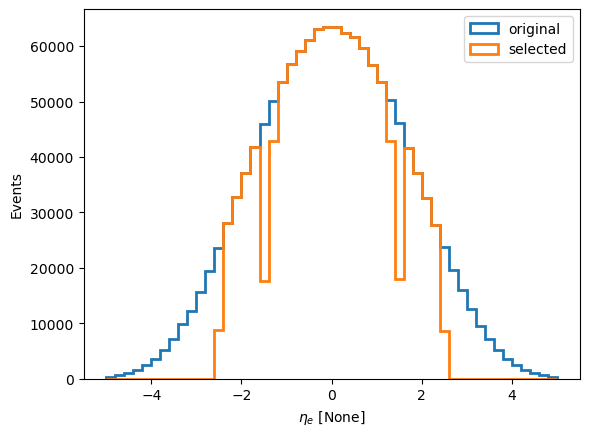

In [10]:
bins_edges = np.linspace(-5, 5, 51)
plt.hist(stored_el_eta, bins=bins_edges, histtype="step", linewidth=2.0, label="original", density=False)
plt.hist(sel_el_eta[gap_mask], bins=bins_edges, histtype="step", linewidth=2.0, label="selected", density=False)
# plt.vlines([-2.47, 2.47], ymin=0, ymax=125_000, color="red", linestyle="--", label=r"$|\eta| < 2.47$") # why not match? -> because binnings are diff!
# plt.ylim(0, 125_000)
plt.xlabel(r"$\eta_{e}$ [None]")
plt.ylabel("Events")
plt.legend()
plt.show()